# HBURS, project 2
by Alessandro G. Magnasco

In [48]:
## System imports

# system library
import os

# math & data operations libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

# machine learning libraries
import mglearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

# charting library
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126378 entries, 0 to 126377
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   BBL            126378 non-null  int64  
 1   OfficialViols  250 non-null     float64
 2   AEP            250 non-null     float64
 3   RepairCount    44128 non-null   float64
 4   RepairCost     44128 non-null   float64
 5   ClassB_count   110092 non-null  float64
 6   ClassB         110092 non-null  float64
 7   ClassC_count   77014 non-null   float64
 8   ClassC         77014 non-null   float64
 9   SumViols       126378 non-null  float64
 10  ViolsDiff      250 non-null     float64
dtypes: float64(10), int64(1)
memory usage: 10.6 MB


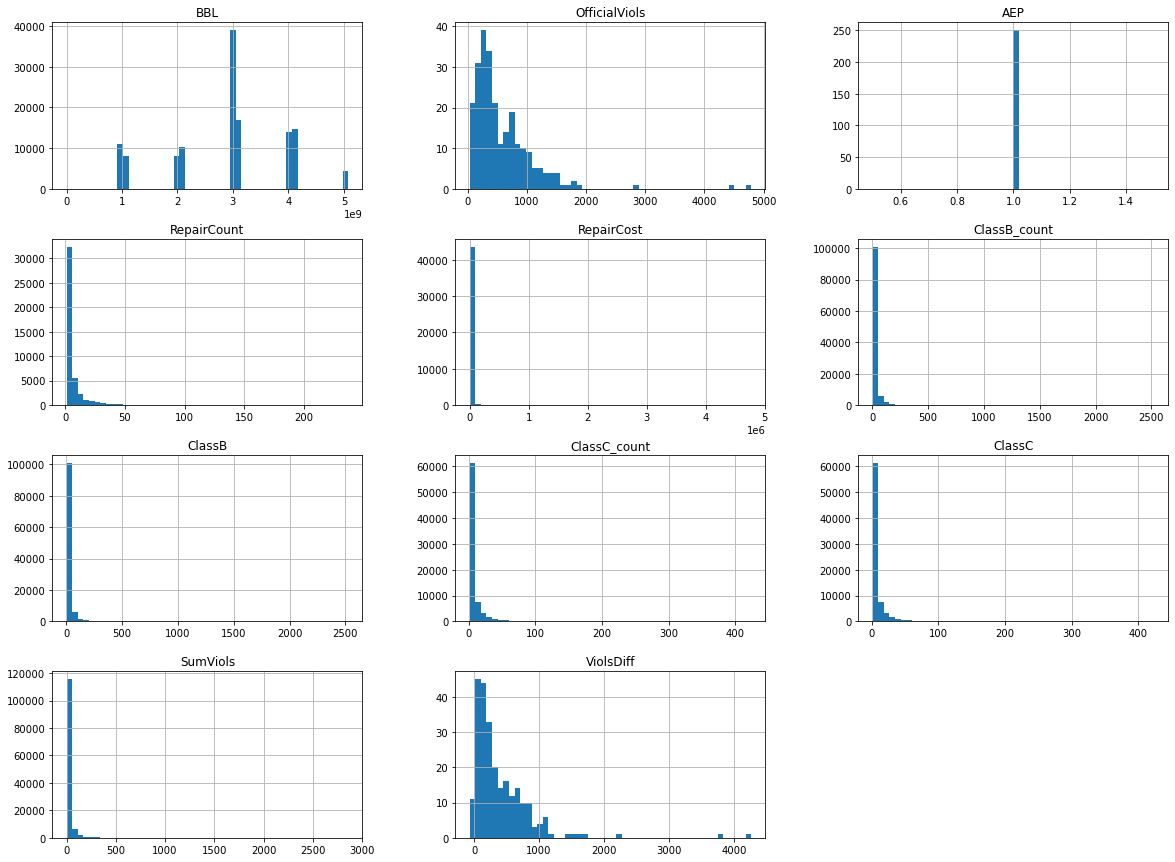

In [2]:
# Step 2.0 - import
bg=0
def import_cleaned_data():
    global bg
    bg = pd.read_csv(r'''bg.csv''', low_memory=False)

import_cleaned_data()
bg.info()

bg.hist(bins=50, figsize=(20,15)) # 20,15
plt.show()

In [3]:
# Step 2.1 - cleaning & split into training/testing

print('Count before dropping NAs: ',bg.count())
# drop any row that contains any NA value in the parameter columns
bg_n = bg.dropna(axis=0,how='any', subset=['RepairCost','ClassB','ClassC','RepairCount'])
print('\n\nCount after dropping NAs: ',bg_n.count())
print(bg_n.head(2000))

# Step 2.2: prepare data, split into features and target
data = bg_n[['RepairCost','ClassB','ClassC','RepairCount']] # selecting features
target = pd.get_dummies(bg_n['AEP']) # converting AEP column to dummies
#target = target_d.reshape(-1,1) # flattening the dummies
print('Data values:\n',data.head())
print('Target values:\n',target[:5])

Count before dropping NAs:  BBL              126378
OfficialViols       250
AEP                 250
RepairCount       44128
RepairCost        44128
ClassB_count     110092
ClassB           110092
ClassC_count      77014
ClassC            77014
SumViols         126378
ViolsDiff           250
dtype: int64


Count after dropping NAs:  BBL              32986
OfficialViols      248
AEP                248
RepairCount      32986
RepairCost       32986
ClassB_count     32986
ClassB           32986
ClassC_count     32986
ClassC           32986
SumViols         32986
ViolsDiff          248
dtype: int64
             BBL  OfficialViols  AEP  RepairCount  RepairCost  ClassB_count  \
0     1002050018          186.0  1.0          6.0     6017.00          67.0   
1     1002390011          169.0  1.0          7.0     2286.00          68.0   
3     1003090021          238.0  1.0          4.0     8722.00          75.0   
4     1003100024          108.0  1.0         14.0   105142.37          37.0   
5    

In [18]:
# stratified shuffle split
split = StratifiedShuffleSplit(
    n_splits=1, 
    test_size=0.2, # 20% testing and 80% training 
    random_state=4 # RNGs always spit out "4" anyway so might as well
)

# using iloc to match the RNG index to the BBL index
for train_index, test_index in split.split(data, target):
    X_train = data.iloc[train_index]
    X_test = data.iloc[test_index]
    y_train_d = target.iloc[train_index]
    y_test_d = target.iloc[test_index]

# converting target sets into 1D arrays
y_train = y_train_d.values.ravel()
y_test = y_test_d.values.ravel()

X_train.describe()

,RepairCost,ClassB,ClassC,RepairCount
count,2.638800e+04,26388.000000,26388.000000,26388.000000
mean,7.690590e+03,42.717599,14.196074,7.184933
std,4.056100e+04,62.929984,21.750395,12.363590
min,0.000000e+00,1.000000,1.000000,1.000000
25%,4.850000e+02,9.000000,3.000000,1.000000
50%,1.569500e+03,23.000000,7.000000,3.000000
75%,5.631150e+03,52.000000,16.000000,8.000000
max,2.576403e+06,2526.000000,424.000000,237.000000


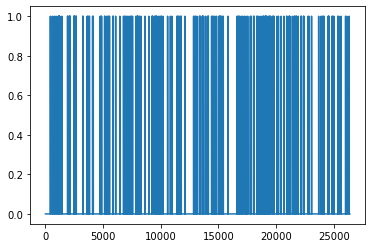

In [23]:
# Step 2.3: examine the target attribute
# Examine and plot the distribution of the target attribute in your training set (e.g., is it Gaussian, uniform, logarithmic). This will help you interpret the performance of different algorithms on your data.

plt.plot(y_train)

(array([26190.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   198.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

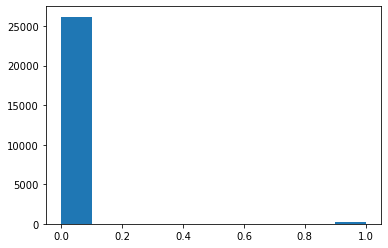

In [26]:
plt.hist(y_train) # we can see that the target attribute is mostly sparse

Histogram: 
 [[<AxesSubplot:title={'center':'RepairCost'}>
  <AxesSubplot:title={'center':'ClassB'}>]
 [<AxesSubplot:title={'center':'ClassC'}>
  <AxesSubplot:title={'center':'RepairCount'}>]] 

Scatterplot Matrix: 
 [[<AxesSubplot:xlabel='RepairCost', ylabel='RepairCost'>
  <AxesSubplot:xlabel='ClassB', ylabel='RepairCost'>
  <AxesSubplot:xlabel='ClassC', ylabel='RepairCost'>
  <AxesSubplot:xlabel='RepairCount', ylabel='RepairCost'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='ClassB'>
  <AxesSubplot:xlabel='ClassB', ylabel='ClassB'>
  <AxesSubplot:xlabel='ClassC', ylabel='ClassB'>
  <AxesSubplot:xlabel='RepairCount', ylabel='ClassB'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='ClassC'>
  <AxesSubplot:xlabel='ClassB', ylabel='ClassC'>
  <AxesSubplot:xlabel='ClassC', ylabel='ClassC'>
  <AxesSubplot:xlabel='RepairCount', ylabel='ClassC'>]
 [<AxesSubplot:xlabel='RepairCost', ylabel='RepairCount'>
  <AxesSubplot:xlabel='ClassB', ylabel='RepairCount'>
  <AxesSubplot:xlabel='ClassC', ylabe

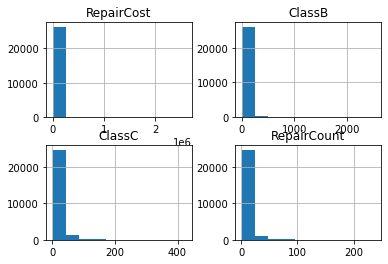

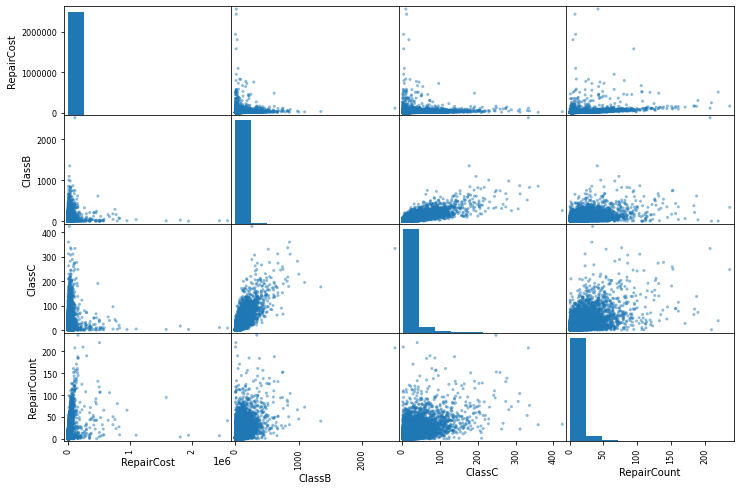

In [45]:
print('Histogram: \n',X_train.hist(),'\n\nScatterplot Matrix: \n',scatter_matrix(X_train, figsize=(12,8)),'\n\n')

             RepairCost    ClassB    ClassC  RepairCount
RepairCost     1.000000  0.127149  0.151046     0.341883
ClassB         0.127149  1.000000  0.792078     0.553253
ClassC         0.151046  0.792078  1.000000     0.610843
RepairCount    0.341883  0.553253  0.610843     1.000000


C:\Users\Ale\AppData\Local\Temp/ipykernel_18540/718141726.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


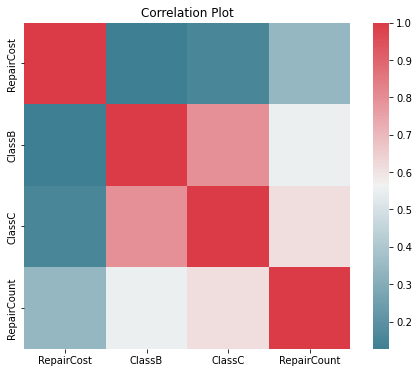

In [49]:
# Pearson correlation matrix
cor= X_train.corr(method='pearson')
print(cor)
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

In [28]:
# Step 2.4: apply two different supervised learning algorithms (default parameters)

# k-nearest neighbours
# this model seems a good fit, since we should be able to clearly group buildings in disrepair 
# k = 5
knn_plain = KNeighborsClassifier(n_neighbors=5)
knn_plain.fit(X_train, y_train)
print("knn score: {}".format(knn_plain.score(X_train, y_train)))

knn score: 0.9924586933454601


In [29]:
# gradient-boosted decision tree

# first, tried decision trees.
# this model seemed like a good fit, since there should be a logical hierarchy for the enforcement decision
# we have low-dimensional sparse mixed data, so curious about its performance
# while precision on "no" values was 0.99, precision on "yes" values was 0.06, so opting for random forest instead
# then, tried random forests
# accuracy on both training and test sets was 0.992
# trying to see if I can boost performance with gradient pre-pruning

gbrt = GradientBoostingClassifier(
    n_estimators=200, 
    random_state=0, # for training
    #max_depth=2, # this appears to be optimal
    #learning_rate=0.1 # appears to be optimal
    )
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.994
Accuracy on test set: 0.991


In [30]:
# the feature importances of the random forest:

print("Feature importances:")
print(gbrt.feature_importances_)

Feature importances:
[0.47423286 0.23285555 0.23512132 0.05779027]


In [31]:
# support vector machine
# this model seems a good fit, since the level of building disrepair could lend itself to a support hyperplane
# would require MinMaxScaler and VarianceThreshold before using, so leaving for future work

### Step 2.5: parameter adjustment

In [32]:
# k-nearest neighbours
# precision, recall, and F1 before adjusting
print(classification_report(y_test, knn_plain.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.99      1.00      1.00      6548
     Yes AEP       0.00      0.00      0.00        50

    accuracy                           0.99      6598
   macro avg       0.50      0.50      0.50      6598
weighted avg       0.98      0.99      0.99      6598



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
# adjust 2-3 parameters using grid search
knn_seasoned = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": np.arange(1, 25)} # setting boundaries on k

# grid search on all values of k in dictionary
knn_gscv = GridSearchCV(knn_seasoned, knn_param_grid, cv=5)
knn_gscv.fit(X_train, y_train)
print('\n\nBest parameters: ',knn_gscv.best_params_)



Best parameters:  {'n_neighbors': 4}


In [36]:
# report evaluation metrics for best- and worst- performing parameter settings
print(classification_report(y_test, knn_gscv.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.99      1.00      1.00      6548
     Yes AEP       0.00      0.00      0.00        50

    accuracy                           0.99      6598
   macro avg       0.50      0.50      0.50      6598
weighted avg       0.98      0.99      0.99      6598



C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ale\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
# gradient-boosted random forest
# precision, recall, and F1
print(classification_report(y_test, gbrt.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))

              precision    recall  f1-score   support

      No AEP       0.99      1.00      1.00      6548
     Yes AEP       0.00      0.00      0.00        50

    accuracy                           0.99      6598
   macro avg       0.50      0.50      0.50      6598
weighted avg       0.98      0.99      0.99      6598



In [ ]:
# adjust 2-3 parameters using grid search
gbrt_seasoned = RandomForestClassifier(random_state=4)

# creating a dictionary with boundaries for each grid search parameter
gbrt_param_grid = { 
    'n_estimators': [200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

gbrt_gscv = GridSearchCV(estimator=gbrt_seasoned, param_grid=gbrt_param_grid, cv=5)
gbrt_gscv.fit(X_train, y_train)

gbrt_gscv.best_params_

In [ ]:
# report evaluation metrics for best- and worst- performing parameter settings
print(classification_report(y_test, gbrt_gscv.predict(X_test),
                            target_names=["No AEP", "Yes AEP"]))